In [1010]:
library('purrr')
library("rstan")
options(mc.cores = parallel::detectCores())

## Bernoulli

In order to have something to work with, we make up a small dataset. The usual datasets for classification are rather big and we will have trouble running the model in stan

In [862]:
X <- matrix(c(
  0, 0, 1, 1, 1,
  1, 0, 1, 1, 0,
  1, 1, 0, 0, 1,
  1, 1, 0, 0, 0,
  0, 1, 0, 0, 1,
  0, 0, 0, 1, 0,
  1, 0, 0, 1, 1,
  1, 1, 0, 0, 1,
  1, 1, 1, 1, 0,
  1, 1, 0, 1, 0,
  1, 1, 0, 1, 1,
  1, 0, 1, 1, 0,
  1, 0, 1, 0, 0
), nrow=13, byrow = TRUE)
y <- rep(c(0, 1), times=c(6, 7))

Fill in the data for the model:

In [863]:
data <- list(
  C = 2,                                  # num categories
  K = dim(X)[2],                          # num features
  N = dim(X)[1],                          # num samples
  y = y + 1,                              # category of sample n
  x = X,                                  # sample n
  alpha = c(1, 1),                        # category prior
  beta = matrix(rep(2, times=10), nrow=2) # feature prior
)

In [865]:
fit <- stan(file = 'model_bernoulli.stan', iter = 20000, data = data, chains = 4)

Inference for Stan model: bayes_bernoulli.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
theta[1]   0.47    0.00 0.12   0.23   0.38   0.47   0.55   0.71 78803    1
theta[2]   0.53    0.00 0.12   0.29   0.45   0.53   0.62   0.77 78803    1
phi[1,1]   0.50    0.00 0.15   0.21   0.39   0.50   0.61   0.79 84883    1
phi[1,2]   0.50    0.00 0.15   0.21   0.39   0.50   0.61   0.79 86284    1
phi[1,3]   0.40    0.00 0.15   0.14   0.29   0.39   0.50   0.70 87035    1
phi[1,4]   0.50    0.00 0.15   0.21   0.39   0.50   0.61   0.79 84768    1
phi[1,5]   0.50    0.00 0.15   0.21   0.39   0.50   0.61   0.79 86212    1
phi[2,1]   0.82    0.00 0.11   0.56   0.75   0.84   0.90   0.97 77061    1
phi[2,2]   0.55    0.00 0.14   0.27   0.44   0.55   0.65   0.81 88170    1
phi[2,3]   0.45    0.00 0.14   0.19   0.35   0.45   0.55   0.74 81637    1
phi[2,4]  

'pars' not specified. Showing first 10 parameters by default.

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



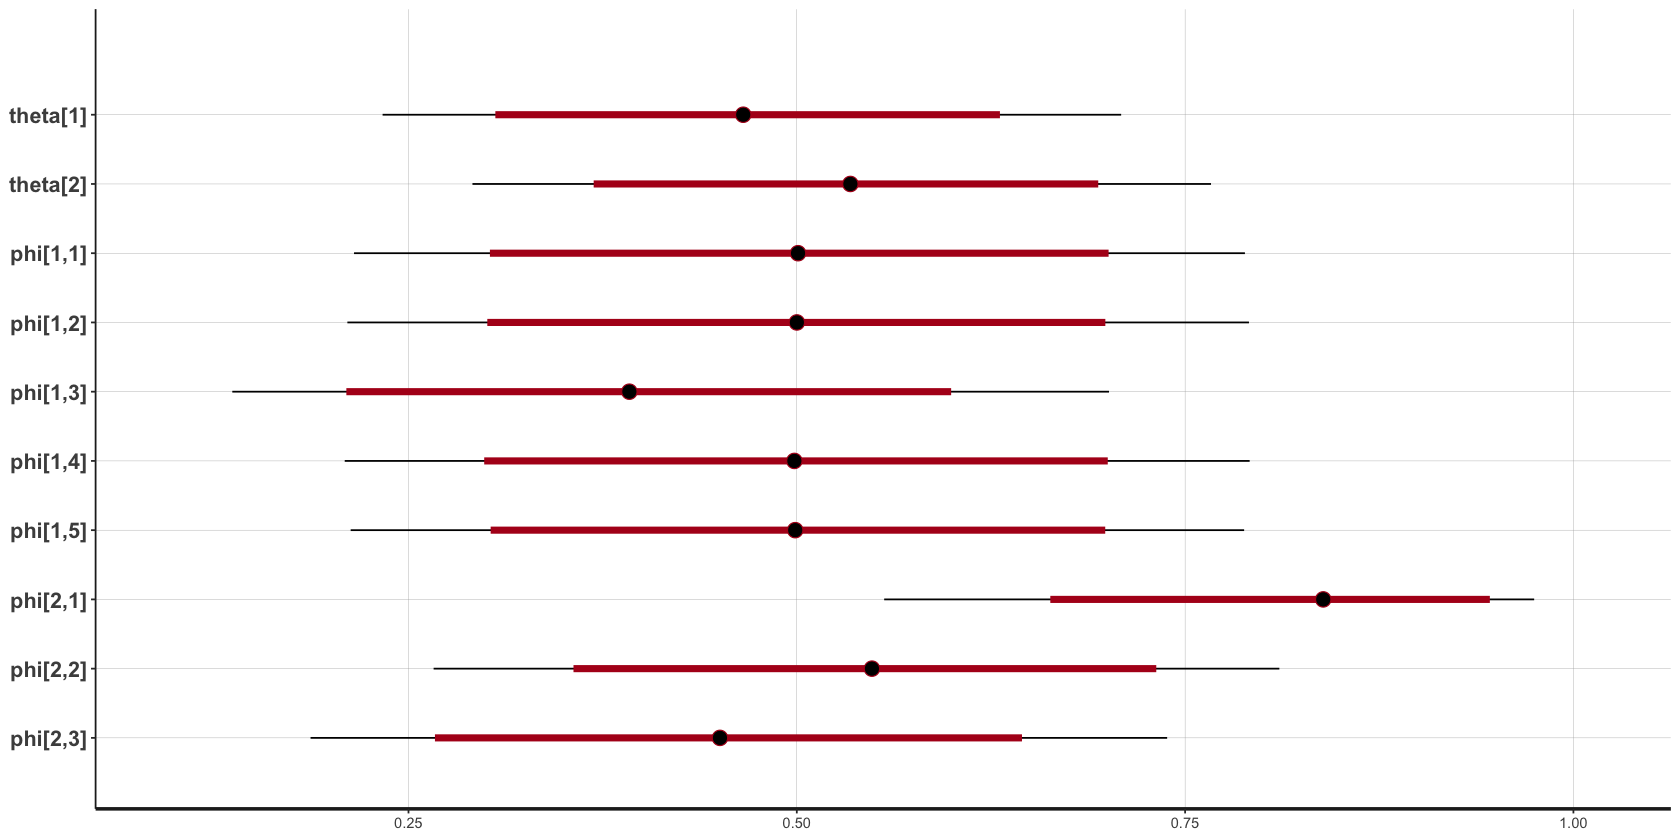

In [ ]:
print(fit)
plot(fit)

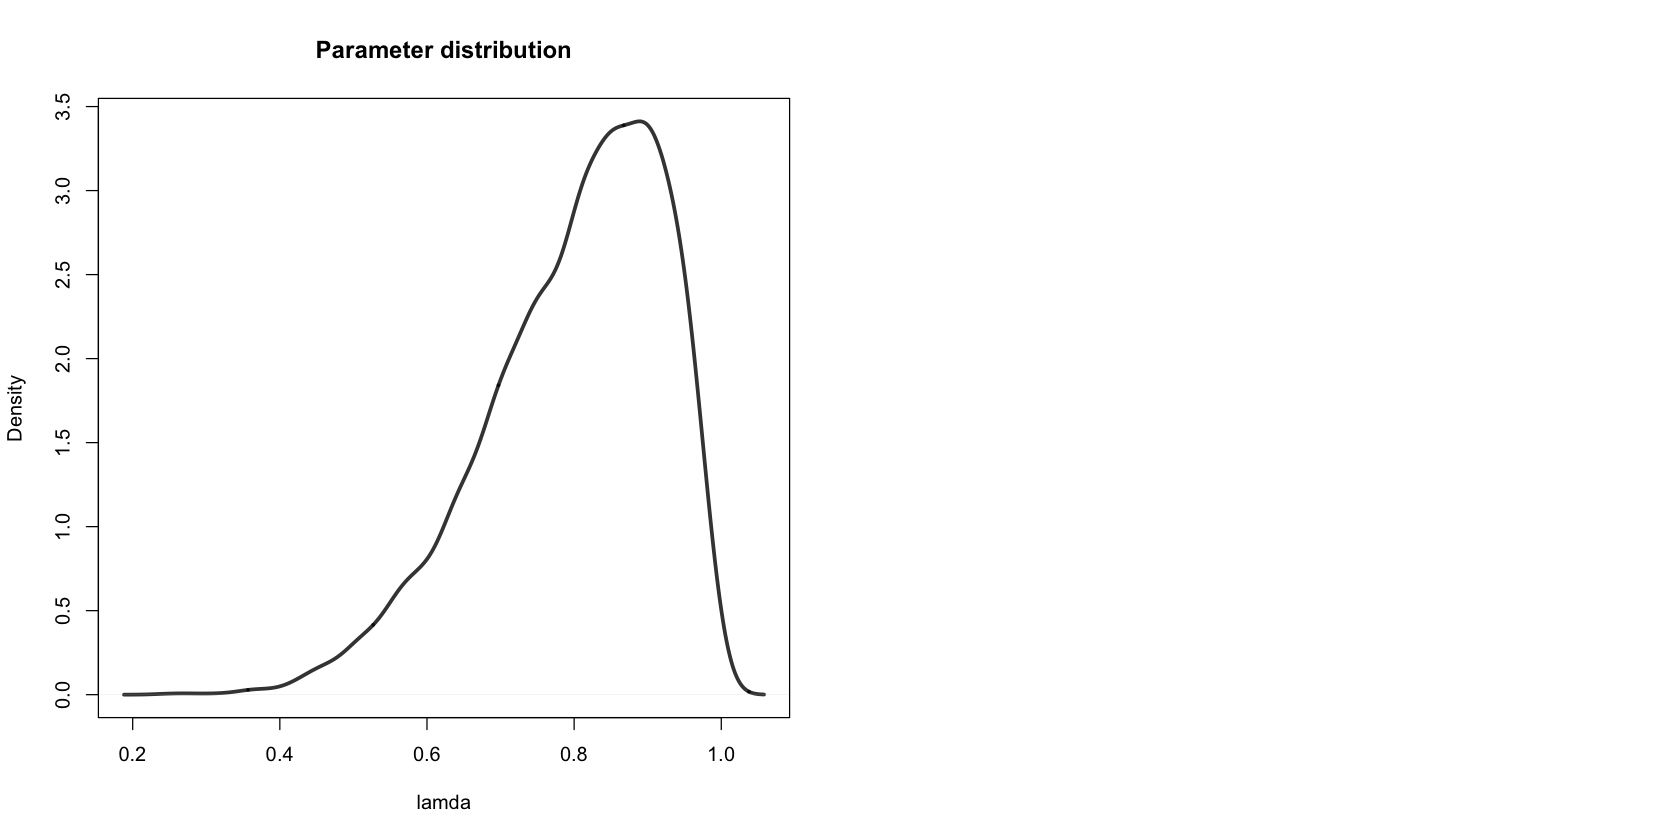

In [ ]:
phi <- unlist(extract(fit, 'phi[1,2]'), use.names = FALSE)
options(repr.plot.width=14,repr.plot.height=7)
old.par<- par(mfrow=c(1,2))
plot(density(phi),
     xlab=expression(lamda), col=grey(0, 0.8),lwd=3,
     main="Parameter distribution")

## Gaussian

We have to center and scale the data so that it may enjoy the same prior over all features

In [1069]:
df <- read.csv('data/Raisin_Dataset.csv')
X <- df[-dim(df)[2]]
# convert the y-vector into numbers instead of strings
y <- map_int(df[['Class']], ~ match(.x, levels(factor(df[['Class']]))))

In [1070]:
# draw a number of random numbers to determine the indices that make up the train set
set.seed(42)
train_size <- floor(0.8 * nrow(df))
ix <- sample(seq_len(nrow(df)), size = train_size)

# use the indices the assign the train and test datasets
X_train <- X[ix,]
X_test <- X[-ix,]
y_train <- y[ix]
y_test <- y[-ix]

# we use scale both the train and test set according to the train set
means <- sapply(X_train, mean)
sds <- sapply(X_train, sd)
X_train <- X_train %>% map2_df(means, `-`) %>% map2_df(sds, `/`)
X_test <- X_test %>% map2_df(means, `-`) %>% map2_df(sds, `/`)

In [1071]:
data <- list(
  C = max(y),              # num categories
  K = ncol(X_train),       # num features
  N = nrow(X_train),       # num samples
  y = y_train,             # category of sample n
  x = X_train,             # sample n
  alpha = rep(1, max(y)),  # category prior
  mu_mu = 0,               # feature mean prior
  mu_sigma = 5,            # feature mean prior
  sigma_alpha = 1,         # feature sd prior
  sigma_beta = 1           # feature sd prior
)

fit <- stan(file = 'model_gaussian.stan', data = data, iter = 10000)

In [1072]:
print(fit)

Inference for Stan model: model_gaussian.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                       mean se_mean   sd     2.5%      25%      50%      75%
theta[1]               0.48    0.00 0.02     0.44     0.47     0.48     0.49
theta[2]               0.52    0.00 0.02     0.48     0.51     0.52     0.53
mu[1,1]                0.65    0.00 0.06     0.54     0.61     0.65     0.69
mu[1,2]                0.70    0.00 0.05     0.60     0.67     0.70     0.73
mu[1,3]                0.52    0.00 0.06     0.41     0.48     0.52     0.55
mu[1,4]                0.45    0.00 0.04     0.37     0.42     0.45     0.47
mu[1,5]                0.65    0.00 0.05     0.54     0.61     0.65     0.69
mu[1,6]               -0.15    0.00 0.06    -0.28    -0.19    -0.15    -0.11
mu[1,7]                0.69    0.00 0.05     0.60     0.66     0.69     0.73
mu[2,1]               -0.60    0.00 0.02    -0.65    -0.62    -0.60 

In [1055]:
# retrieve the stan summary object
smry <- summary(fit)$summary

# retrieve our parameters from the summary
mus <- smry[grepl('mu',row.names(smry)),'mean']
sigmas <- smry[grepl('sigma\\[',row.names(smry)),'mean']
thetas <- smry[grepl('theta',row.names(smry)),'mean'] %>% as.vector

# adjust the dimensions so that they are (features, classes)
dim(mus) <- c(data$K, data$C)
dim(sigmas) <- c(data$K, data$C)

In [1056]:
# make a prediction by looping over each individual sample
y_pred <- lapply(1:nrow(X_test), \(i) as.matrix(X_test[i,]) |>
  matrix(ncol=ncol(X)) |>                         # shape the sample so that it broadcasts correctly
  dnorm(mean = mus, sd = sigmas, log = TRUE) |>   # calculate the pd for the various features over all classes
  colSums() |>                                    # sum the pds
  (\(x) x + log(thetas))() |>                     # add class probabilities (sometimes refered to as priors)
  which.max()                                     # predict the class
)

In [1057]:
mean(y_pred==y_test)

[1] 0.8611111

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



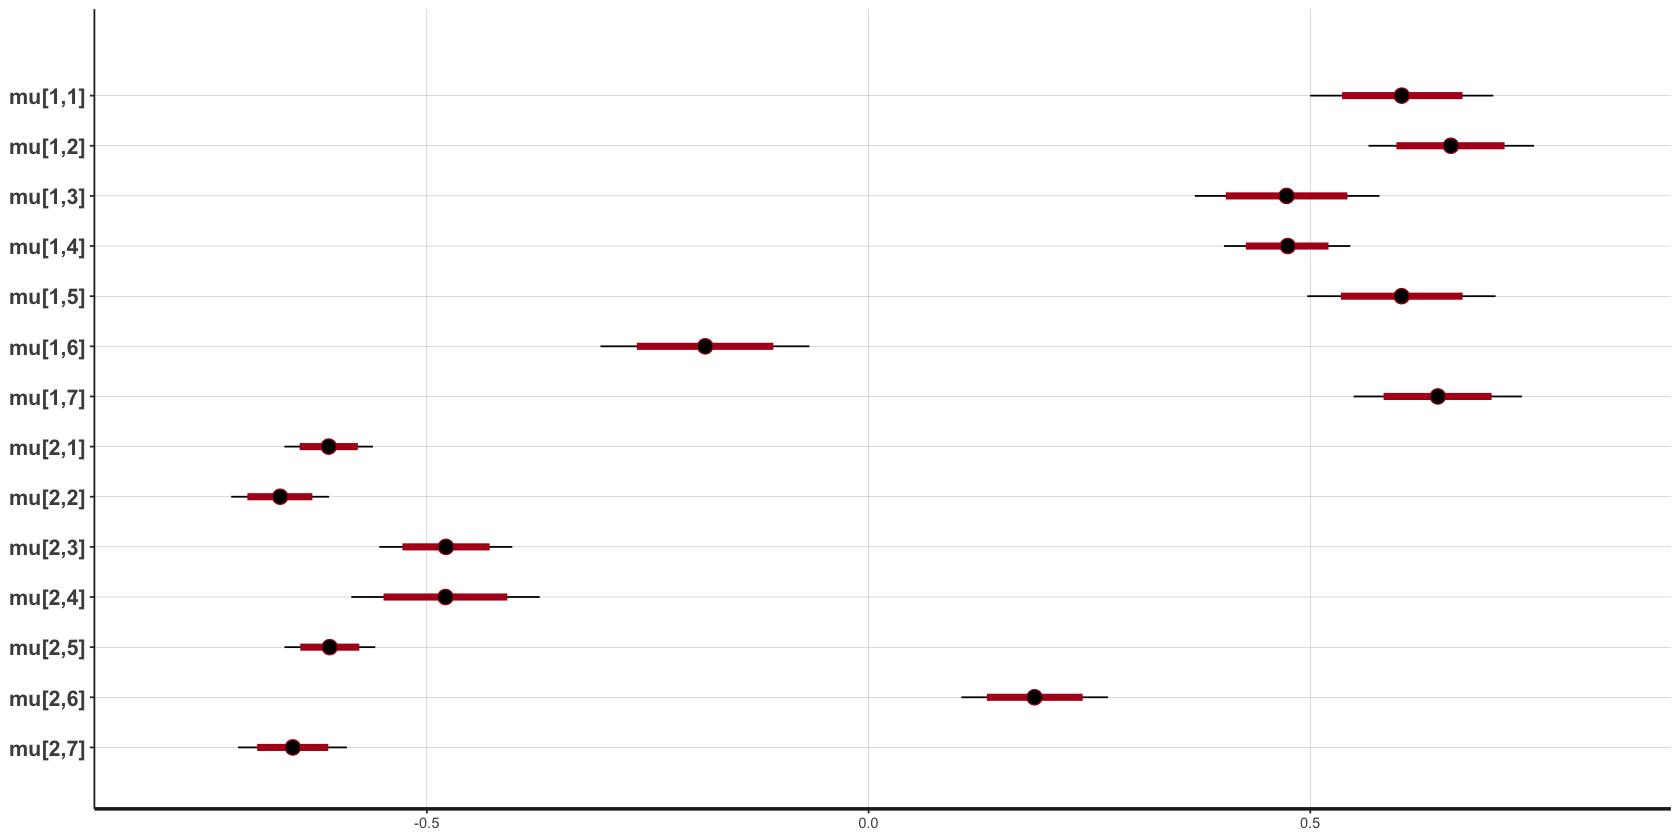

In [1065]:
stan_plot(fit, c('mu'))

## Multinomial

In [252]:
# y <- map_int(dat, ~ substr(.x, 1, 1) %>% strtoi) + 1
# corpus <- map(dat, ~ substring(.x, 3) %>% tolower %>% strsplit("[^\\w]+", perl=TRUE))
# words <- unlist(corpus)
# vocab <- unique(words)
# word_ids <- map_int(words, ~ match(.x, vocab))
# doc_ids <- rep(y, times=map(flatten(corpus), length))
# V <- length(vocab)
# word_counts <- map_int(vocab, ~ sum(words == .x))

In [1073]:
library('stopwords')
dat = readLines('https://raw.githubusercontent.com/arthurratz/bayes_classifier_multi/main/bayes_classifier_multi/dataset/trainset.txt')

# maximum vocabulary size, the other words will be discarded
max_words <- 100

# get the classes from the dataset
y <- map_int(dat, ~ substr(.x, 1, 1) %>% strtoi) + 1
# retrieve the sentences, preprocess them and tokenize
corpus <- map(dat, ~ substring(.x, 3) %>%
    tolower %>%
    strsplit("[^\\w]+", perl=TRUE) %>%
    unlist %>%
    keep(~ nchar(.x) > 1))

# remove the stopwords and get a table of the 100 most common
# words and their frequencies
words <- unlist(corpus)
words <- words[!words %in% stopwords::stopwords('en')]
vocab <- sort(table(words), decreasing = TRUE)[1:max_words]

# filter the corpus by words that are in the vocabulary
corpus <- map(corpus, ~ keep(.x, ~ .x %in% names(vocab)))
# list of all the words in the corpus (repeating)
words <- unlist(corpus)

# lists of word ids and doc ids for every word
word_ids <- map_int(words, ~ match(.x, names(vocab)))
doc_ids <- rep(y, times=map(corpus, length))
V <- length(vocab)

Warning message in readLines("https://raw.githubusercontent.com/arthurratz/bayes_classifier_multi/main/bayes_classifier_multi/dataset/trainset.txt"):
“incomplete final line found on 'https://raw.githubusercontent.com/arthurratz/bayes_classifier_multi/main/bayes_classifier_multi/dataset/trainset.txt'”


In [1074]:
data <- list(
  K = max(y),               # num topics
  V = V,                    # num words
  M = length(corpus),       # num docs
  N = length(word_ids),     # total word instances
  z = y,                    # topic for doc m
  w = word_ids,             # word n
  doc = doc_ids,            # doc ID for word n
  alpha = rep(1, max(y)),   # topic prior
  beta = rep(1, max_words)  # word prior
)

fit <- stan(file = 'model_multinomial.stan', data = data, iter = 20000)

In [1076]:
print(fit)

Inference for Stan model: model_multinomial.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

               mean se_mean    sd     2.5%      25%      50%      75%    97.5%
theta[1]       0.24    0.00  0.05     0.14     0.20     0.24     0.27     0.35
theta[2]       0.21    0.00  0.05     0.12     0.17     0.20     0.24     0.31
theta[3]       0.19    0.00  0.05     0.10     0.16     0.19     0.22     0.30
theta[4]       0.19    0.00  0.05     0.10     0.16     0.19     0.22     0.29
theta[5]       0.17    0.00  0.05     0.09     0.14     0.17     0.20     0.28
phi[1,1]       0.03    0.00  0.01     0.02     0.03     0.03     0.04     0.05
phi[1,2]       0.03    0.00  0.01     0.02     0.02     0.03     0.03     0.05
phi[1,3]       0.03    0.00  0.01     0.01     0.02     0.02     0.03     0.04
phi[1,4]       0.02    0.00  0.01     0.01     0.01     0.02     0.02     0.03
phi[1,5]       0.02    0.00  0.01     0.01 

In [1081]:
# retrieve the stan summary object
smry <- summary(fit)$summary

# retrieve our parameters from the summary
phis <- smry[grepl('phi',row.names(smry)),'mean']
thetas <- smry[grepl('theta',row.names(smry)),'mean'] %>% as.vector

# adjust the dimensions so that they are (features, classes)
dim(phis) <- c(data$K, data$V)

In [1085]:
# make a prediction by looping over each individual sample
y_pred <- lapply(1:nrow(X), \(i) as.matrix(X[i,]) |>
  matrix(ncol=ncol(X)) |>                         # shape the sample so that it broadcasts correctly
  dmultinom(prob = phis, log = TRUE) |>   # calculate the pd for the various features over all classes
  colSums() |>                                    # sum the pds
  (\(x) x + log(thetas))() |>                     # add class probabilities (sometimes refered to as priors)
  which.max()                                     # predict the class
)

ERROR: Error in dmultinom(matrix(as.matrix(X[i, ]), ncol = ncol(X)), prob = phis, : x[] and prob[] must be equal length vectors.


In [1086]:
as.matrix(X[1,])

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
1,87524,442.246,253.2912,0.8197384,90546,0.7586506,1184.04
